In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Detectron2_with_teeth/train/_annotations.coco.json", "/content/drive/MyDrive/Detectron2_with_teeth/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Detectron2_with_teeth/valid/_annotations.coco.json", "/content/drive/MyDrive/Detectron2_with_teeth/valid")


In [ ]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[03/26 15:59:08 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Detectron2_with_teeth/train/_annotations.coco.json takes 1.19 seconds.
WARNING [03/26 15:59:08 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/26 15:59:08 d2.data.datasets.coco]: Loaded 268 images in COCO format from /content/drive/MyDrive/Detectron2_with_teeth/train/_annotations.coco.json
WARNING [03/26 15:59:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/26 15:59:09 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/drive/MyDrive/Detectron2_with_teeth/valid/_annotations.coco.json


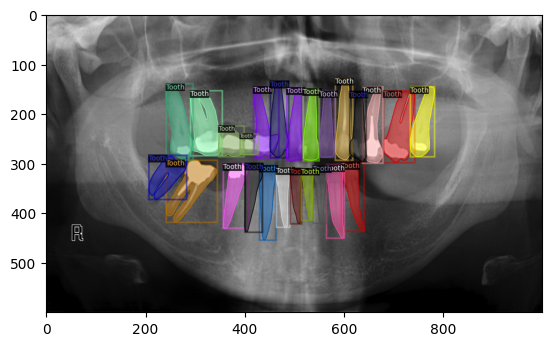

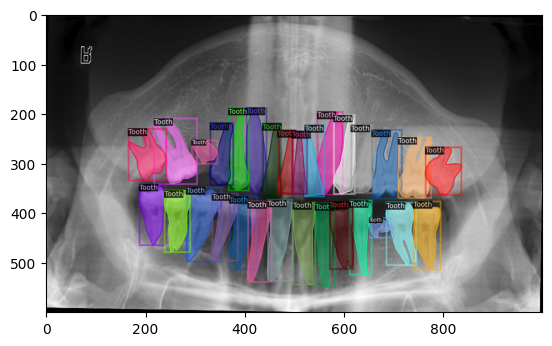

In [ ]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()


In [ ]:
from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Detectron2_with_teeth/model_storage"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 2500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)


[03/26 16:00:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 89.2MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [ ]:
trainer.train()

In [ ]:
import yaml
config_yaml_path = "/content/drive/MyDrive/Detectron2_with_teeth/model_storage/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Detectron2_with_teeth/model_storage/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

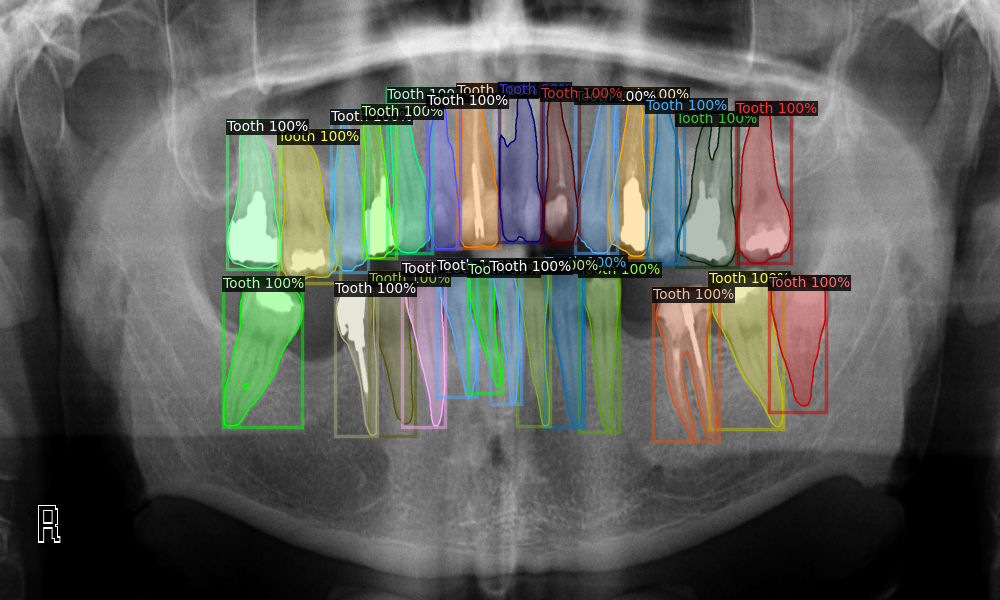

In [ ]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/26 16:32:02 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [03/26 16:32:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/26 16:32:02 d2.data.datasets.coco]: Loaded 4 images in COCO format from /content/drive/MyDrive/Detectron2_with_teeth/valid/_annotations.coco.json
[03/26 16:32:02 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   tooth    | 0            |   Tooth    | 108          |
|            |              |            |              |
|   total    | 108          |            |              |
[03/26 16:32:02 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/26 16:32:02 d2.data.common]: Serializing the

In [ ]:
new_im = cv2.imread("/content/drive/MyDrive/Detectron2_with_teeth/test/111_png.rf.856550f5d3c87af670af666e26c13958.jpg")
outputs  = predictor(new_im)

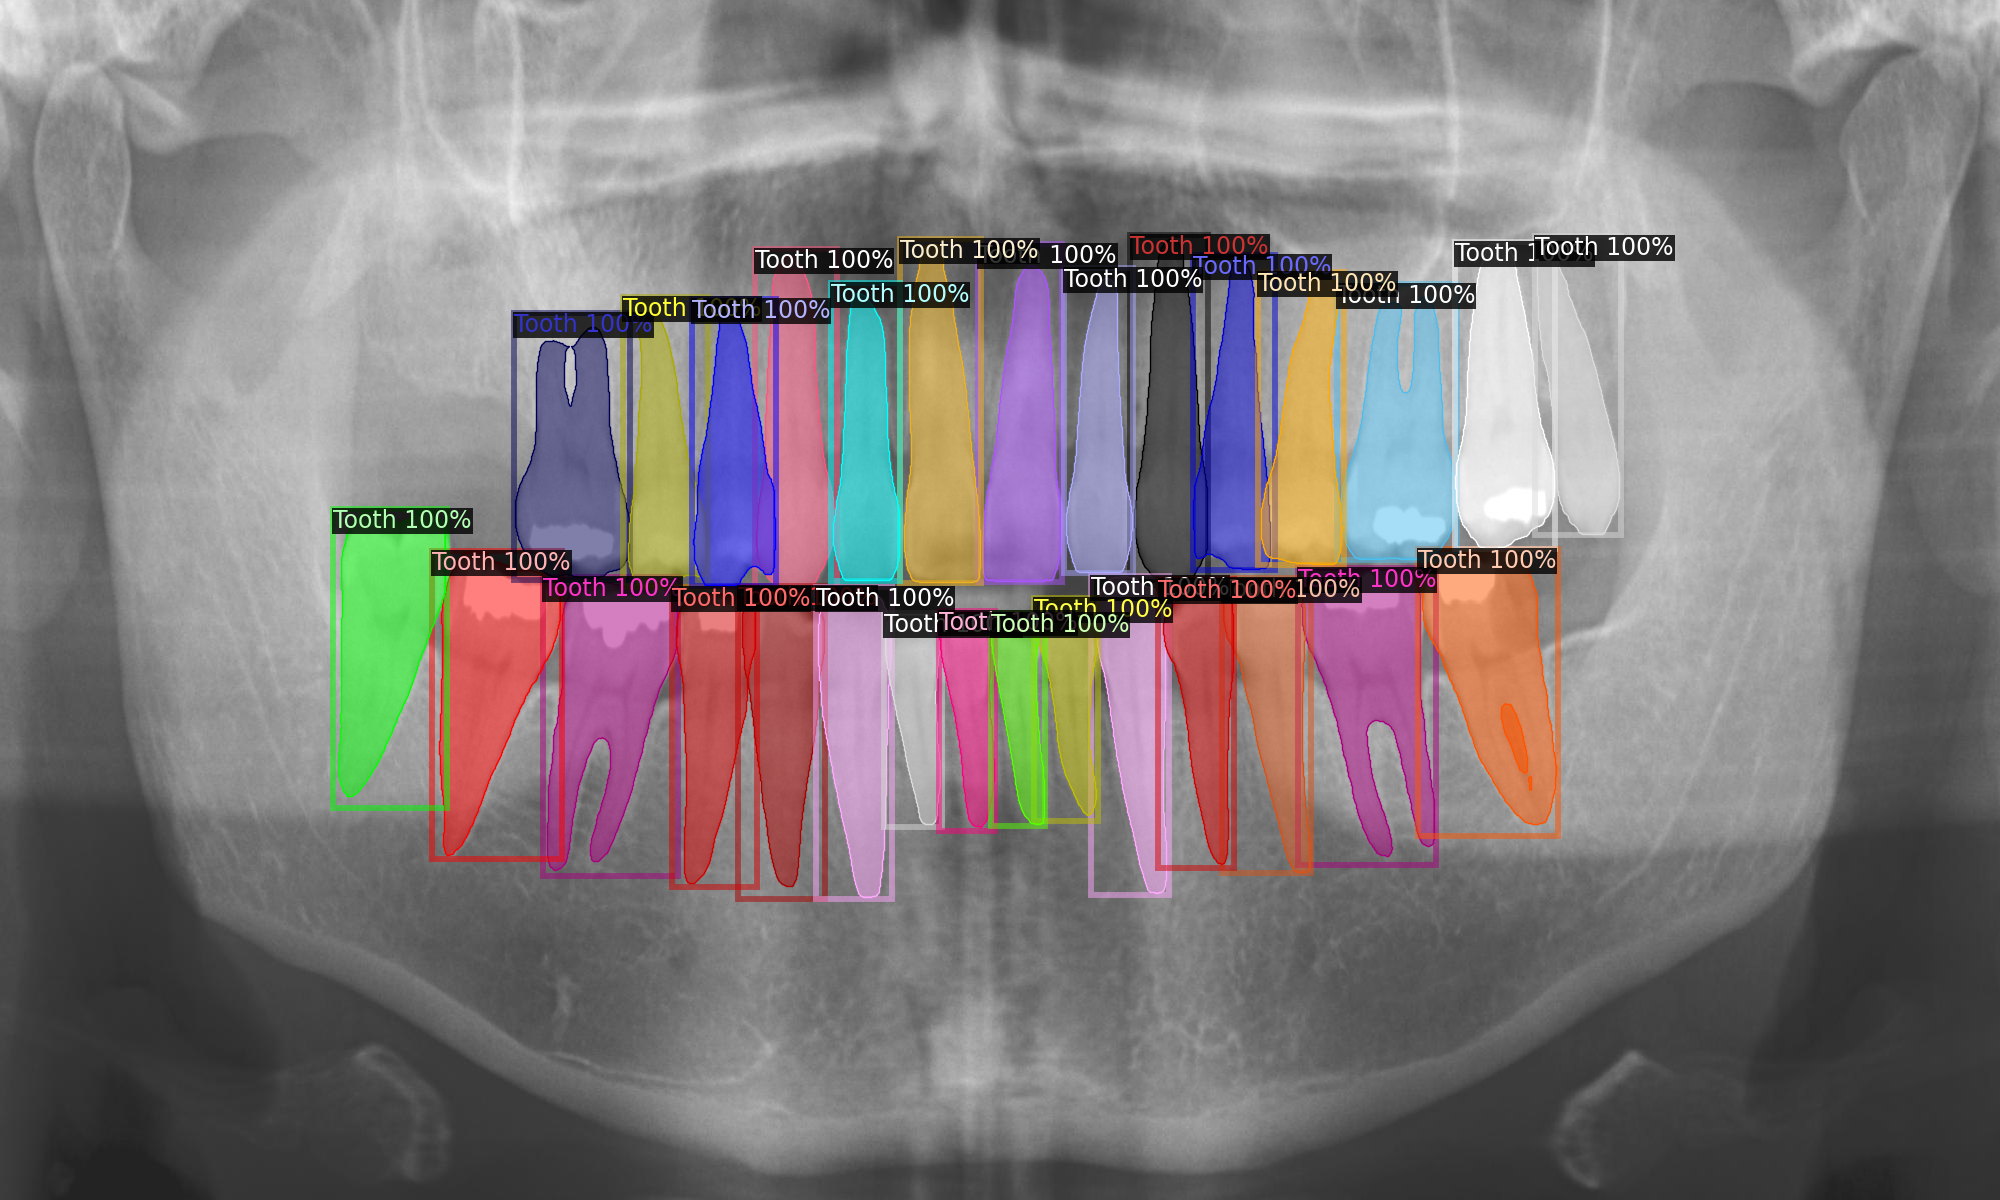

In [ ]:
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
input_images_directory = "/content/drive/MyDrive/Detectron2_with_teeth/all_teeth_images"
output_directory = "/content/drive/MyDrive/Detectron2_with_teeth/predicted_detected_segmented_results"
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)
    outputs = predictor(new_im)
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])
print("Segmentation of all images completed.")

Segmentation of all images completed.


In [ ]:
import csv
from skimage.measure import regionprops, label
input_images_directory = "/content/drive/MyDrive/Detectron2_with_teeth/all_teeth_images"
output_csv_path = "/content/drive/MyDrive/Detectron2_with_teeth/predicted_detected_segmented_results/output_recognized_objects.csv"
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)
        if new_im is not None:
            outputs = predictor(new_im)
            mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)
            class_labels = outputs["instances"].pred_classes.to("cpu").numpy()
            labeled_mask = label(mask)
            if labeled_mask.size > 0:
                props = regionprops(labeled_mask)
                for i, prop in enumerate(props):
                    object_number = i + 1
                    area = prop.area
                    centroid = prop.centroid
                    bounding_box = prop.bbox
                    if i < len(class_labels):
                        class_label = class_labels[i]
                        class_name = train_metadata.thing_classes[class_label]
                    else:
                        class_name = 'Unknown'
                    csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# csv_file_path = "/content/drive/MyDrive/Detectron2_with_teeth/predicted_detected_segmented_results/output_recognized_objects.csv"
# df = pd.read_csv(csv_file_path)
# class_names = train_metadata.thing_classes
# avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
# avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()
# plt.figure(figsize=(5, 5))
# sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, errorbar=None, order=class_names)
# plt.xticks(rotation=45)
# plt.xlabel("Class Name")
# plt.ylabel("Average Number of Objects per Image")
# plt.title("Average Number of Objects per Image for Each Class")
# plt.tight_layout()
# plt.show()
# avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()
# plt.figure(figsize=(5, 5))
# sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, errorbar=None, order=class_names)
# plt.xticks(rotation=45)
# plt.xlabel("Class Name")
# plt.ylabel("Average Area of Objects")
# plt.title("Average Area of Objects for Each Class")
# plt.tight_layout()
# plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
predictor = detectron2.engine.defaults.DefaultPredictor(cfg)
train_metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
input_images_directory = "/content/drive/MyDrive/Detectron2_with_teeth/all_teeth_images"
output_directory = "/content/drive/MyDrive/Detectron2_with_teeth/predicted_ground_truths_test_images"
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)
    if new_im is not None:
        outputs = predictor(new_im)
        if len(outputs["instances"].pred_masks) > 0:
            class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                        for class_name in train_metadata.thing_classes}
            for i, pred_class in enumerate(outputs["instances"].pred_classes):
                class_name = train_metadata.thing_classes[pred_class]
                class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                                    i + 1,
                                                    class_masks[class_name])
            for class_name, class_mask in class_masks.items():
                class_mask_np = class_mask.cpu().numpy()
                class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
                class_output_path = os.path.join(output_directory, class_filename)
                cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))
print("Segmentation of all images completed.")

Segmentation of all images completed.
